# 0. Load python libs

In [1]:
import os
import glob
import json
import nmrglue as ng
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle
import pandas as pd
import random
import math
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict, OrderedDict

from scipy import interpolate

%matplotlib inline

In [2]:
from lib.carrier import SpectraCarrier
import lib.utils as utils

In [3]:
import rdkit
print(rdkit.__version__)

from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

2020.09.1


In [4]:
from lib.ifg import identify_functional_groups

In [5]:
pd.set_option('display.max_columns', None)

# 1. Load dataframes

In [6]:
DATA_DIR = './data'
SOURCE_DIR = './data/source'
TARGET_DIR = './data/target'

In [7]:
fn_train_df = '{}/train_df.pk'.format(SOURCE_DIR)
fn_valid_df = '{}/valid_df.pk'.format(SOURCE_DIR)
fn_test_df = '{}/test_df.pk'.format(SOURCE_DIR)

In [8]:
loaded_train_df = None
with open(fn_train_df, 'rb') as file:
    loaded_train_df = pickle.load(file)
    
loaded_valid_df = None
with open(fn_valid_df, 'rb') as file:
    loaded_valid_df = pickle.load(file)
    
loaded_test_df = None
with open(fn_test_df, 'rb') as file:
    loaded_test_df = pickle.load(file)

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [10]:
loaded_train_df.head(3)

,fn,cano_smi,CO,cOC,"COC(-,:C)=O",cnc,cCl,cO,CCl,"CC(-,:C)=O",cBr,c[N&+](=O)[O&-],"cC(-,:C)=O",C=CC,cN,cC(=O)OC,COC,CF,CBr,coc,cF,CC(=O)O,c=O,c[n&H1]c,csc,cC=O,CNC,CN,"CN(-,:C)C",cC#N,"cn(-,:c)C",cC(=O)O,"CC=C(-,:C)C",CC#N,"cNC(-,:C)=O",cNC,C/C=C/C,CC=CC,"C=C(-,:C)C",C#CC,"cC(-,:c)=O","cN(-,:C)C",CC(=O)OC,CC#CC,cI,"CNC(-,:C)=O",cC=Cc,"c-n(-,:c)c","cnn(-,:c)C",cnnc,"cP(-,:c)c",CS,spectrum,(W)-CO,(W)-cOC,"(W)-COC(-,:C)=O",(W)-cnc,(W)-cCl,(W)-cO,(W)-CCl,"(W)-CC(-,:C)=O",(W)-cBr,(W)-c[N&+](=O)[O&-],"(W)-cC(-,:C)=O",(W)-C=CC,(W)-cN,(W)-cC(=O)OC,(W)-COC,(W)-CF,(W)-CBr,(W)-coc,(W)-cF,(W)-CC(=O)O,(W)-c=O,(W)-c[n&H1]c,(W)-csc,(W)-cC=O,(W)-CNC,(W)-CN,"(W)-CN(-,:C)C",(W)-cC#N,"(W)-cn(-,:c)C",(W)-cC(=O)O,"(W)-CC=C(-,:C)C",(W)-CC#N,"(W)-cNC(-,:C)=O",(W)-cNC,(W)-C/C=C/C,(W)-CC=CC,"(W)-C=C(-,:C)C",(W)-C#CC,"(W)-cC(-,:c)=O","(W)-cN(-,:C)C",(W)-CC(=O)OC,(W)-CC#CC,(W)-cI,"(W)-CNC(-,:C)=O",(W)-cC=Cc,"(W)-c-n(-,:c)c","(W)-cnn(-,:c)C",(W)-cnnc,"(W)-cP(-,:c)c",(W)-CS
0,1136-86-3,COc1cc(C(C)=O)cc(OC)c1OC,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0.567877,7.202310,0.540732,0.532957,0.53604,0.528167,0.526322,0.521537,0.516949,0.519961,15.059375,0.519177,0.518284,0.516174,0.516174,0.51474,0.515511,0.512442,0.513315,0.511245,0.510595,0.509516,0.508978,0.508226,0.508441,0.508548,0.508441,0.505985,0.507156,0.50705,0.506836,0.50673,0.505772,0.505879,0.505348,0.505985,0.505666,0.505666,0.505348,0.50556,0.505242,0.505136,0.504713,0.504185,0.504079,0.501979,0.503132,0.502398,0.502922,0.502398
3,610-54-8,CCOc1ccc([N+](=O)[O-])cc1[N+](=O)[O-],0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0.567877,7.202310,0.540732,0.532957,0.53604,0.528167,0.526322,0.521537,0.516949,14.326757,0.518953,0.519177,0.518284,0.516174,0.516174,0.51474,0.515511,0.512442,0.513315,0.511245,0.510595,0.509516,0.508978,0.508226,0.508441,0.508548,0.508441,0.505985,0.507156,0.50705,0.506836,0.50673,0.505772,0.505879,0.505348,0.505985,0.505666,0.505666,0.505348,0.50556,0.505242,0.505136,0.504713,0.504185,0.504079,0.501979,0.503132,0.502398,0.502922,0.502398
5,645-36-3,CCOC(CN)OCC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0.567877,0.541339,0.540732,0.532957,0.53604,0.528167,0.526322,0.521537,0.516949,0.519961,0.518953,0.519177,0.518284,0.516174,0.516174,0.51474,0.515511,0.512442,0.513315,0.511245,0.510595,0.509516,0.508978,0.508226,0.508441,32.721605,0.508441,0.505985,0.507156,0.50705,0.506836,0.50673,0.505772,0.505879,0.505348,0.505985,0.505666,0.505666,0.505348,0.50556,0.505242,0.505136,0.504713,0.504185,0.504079,0.501979,0.503132,0.502398,0.502922,0.502398


In [11]:
loaded_train_df.tail(3)

,fn,cano_smi,CO,cOC,"COC(-,:C)=O",cnc,cCl,cO,CCl,"CC(-,:C)=O",cBr,c[N&+](=O)[O&-],"cC(-,:C)=O",C=CC,cN,cC(=O)OC,COC,CF,CBr,coc,cF,CC(=O)O,c=O,c[n&H1]c,csc,cC=O,CNC,CN,"CN(-,:C)C",cC#N,"cn(-,:c)C",cC(=O)O,"CC=C(-,:C)C",CC#N,"cNC(-,:C)=O",cNC,C/C=C/C,CC=CC,"C=C(-,:C)C",C#CC,"cC(-,:c)=O","cN(-,:C)C",CC(=O)OC,CC#CC,cI,"CNC(-,:C)=O",cC=Cc,"c-n(-,:c)c","cnn(-,:c)C",cnnc,"cP(-,:c)c",CS,spectrum,(W)-CO,(W)-cOC,"(W)-COC(-,:C)=O",(W)-cnc,(W)-cCl,(W)-cO,(W)-CCl,"(W)-CC(-,:C)=O",(W)-cBr,(W)-c[N&+](=O)[O&-],"(W)-cC(-,:C)=O",(W)-C=CC,(W)-cN,(W)-cC(=O)OC,(W)-COC,(W)-CF,(W)-CBr,(W)-coc,(W)-cF,(W)-CC(=O)O,(W)-c=O,(W)-c[n&H1]c,(W)-csc,(W)-cC=O,(W)-CNC,(W)-CN,"(W)-CN(-,:C)C",(W)-cC#N,"(W)-cn(-,:c)C",(W)-cC(=O)O,"(W)-CC=C(-,:C)C",(W)-CC#N,"(W)-cNC(-,:C)=O",(W)-cNC,(W)-C/C=C/C,(W)-CC=CC,"(W)-C=C(-,:C)C",(W)-C#CC,"(W)-cC(-,:c)=O","(W)-cN(-,:C)C",(W)-CC(=O)OC,(W)-CC#CC,(W)-cI,"(W)-CNC(-,:C)=O",(W)-cC=Cc,"(W)-c-n(-,:c)c","(W)-cnn(-,:c)C",(W)-cnnc,"(W)-cP(-,:c)c",(W)-CS
6288,a5e81bc8-7cd1-4603-bf77-d6635351f25b,CC1=CC[C@@H](C2(C)CC2(C)C(=O)OC(C)(C)C)CC1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0.9202703349311558, 0.9234971350037704, 0.926...",0.567877,0.541339,7.301515,0.532957,0.53604,0.528167,0.526322,0.521537,0.516949,0.519961,0.518953,0.519177,0.518284,0.516174,0.516174,0.51474,0.515511,0.512442,0.513315,0.511245,0.510595,0.509516,0.508978,0.508226,0.508441,0.508548,0.508441,0.505985,0.507156,0.50705,40.776154,0.50673,0.505772,0.505879,0.505348,0.505985,0.505666,0.505666,0.505348,0.50556,0.505242,0.505136,0.504713,0.504185,0.504079,0.501979,0.503132,0.502398,0.502922,0.502398
6289,427ee4cc-e725-4b40-829d-51b14984e029,Brc1cnc2ccccc2n1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0.6751178997222926, 0.6719449948267988, 0.668...",0.567877,0.541339,0.540732,8.894128,0.53604,0.528167,0.526322,0.521537,16.775000,0.519961,0.518953,0.519177,0.518284,0.516174,0.516174,0.51474,0.515511,0.512442,0.513315,0.511245,0.510595,0.509516,0.508978,0.508226,0.508441,0.508548,0.508441,0.505985,0.507156,0.50705,0.506836,0.50673,0.505772,0.505879,0.505348,0.505985,0.505666,0.505666,0.505348,0.50556,0.505242,0.505136,0.504713,0.504185,0.504079,0.501979,0.503132,0.502398,0.502922,0.502398
6290,dcf80c78-98e2-4ef9-b8a8-bc259aa8f9a4,CCCC[Sn](CCCC)(CCCC)c1cnc2ccccc2n1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0.5719682556458464, 0.5722615937762792, 0.571...",0.567877,0.541339,0.540732,8.894128,0.53604,0.528167,0.526322,0.521537,0.516949,0.519961,0.518953,0.519177,0.518284,0.516174,0.516174,0.51474,0.515511,0.512442,0.513315,0.511245,0.510595,0.509516,0.508978,0.508226,0.508441,0.508548,0.508441,0.505985,0.507156,0.50705,0.506836,0.50673,0.505772,0.505879,0.505348,0.505985,0.505666,0.505666,0.505348,0.50556,0.505242,0.505136,0.504713,0.504185,0.504079,0.501979,0.503132,0.502398,0.502922,0.502398


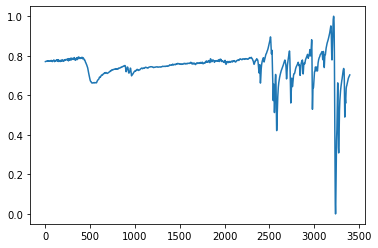

In [12]:
plt.plot(loaded_test_df.iloc[-1:]['spectrum'].values[0][::-1])

# 2. Dataset composition

### These datasets contain NIST `basic information` & KIT complat in-house `spectra`.

Since we are not in the position to distribute NIST spectra, saved dataframes in this repository only have: 

1. NIST filenames and canonic SMILES without spectra.
2. KIT complat in-house filenames and canonic SMILES with spectra in the `spectrum` column.

- Therefore, we can know how many NIST and in-house SMILES by checking the `spectrum` column.
- After you get NIST spectra, NIST spectra will be loaded in the next notebook.
- To purchase NIST spectra : __TBD__.

In [13]:
print('Training dataset count {} / NIST {} / complat {}'.format(loaded_train_df.shape[0], loaded_train_df['spectrum'].isnull().sum(), loaded_train_df.shape[0] - loaded_train_df['spectrum'].isnull().sum()))
print('Validation dataset count {} / NIST {} / complat {}'.format(loaded_valid_df.shape[0], loaded_valid_df['spectrum'].isnull().sum(), loaded_valid_df.shape[0] - loaded_valid_df['spectrum'].isnull().sum()))
print('Testing dataset count {} / NIST {} / complat {}'.format(loaded_test_df.shape[0], loaded_test_df['spectrum'].isnull().sum(), loaded_test_df.shape[0] - loaded_test_df['spectrum'].isnull().sum()))

Training dataset count 4819 / NIST 3930 / complat 889
Validation dataset count 733 / NIST 557 / complat 176
Testing dataset count 739 / NIST 579 / complat 160


# 3. Function groups

In [14]:
def clear_mapnum(mol):
    [
        atom.ClearProp('molAtomMapNumber')
        for atom in mol.GetAtoms()
        if atom.HasProp('molAtomMapNumber')
    ]

def extract_fgs(mol):
    fg_smas = []
    fgs = identify_functional_groups(mol)

    for fg in fgs:
        target = fg.type
        mol = Chem.MolFromSmarts(target)
        clear_mapnum(mol)
        sma = Chem.MolToSmarts(mol)
        fg_smas.append(sma)

    return list(set(fg_smas))

In [15]:
fg_dict = {}
for idx, csmi in enumerate(loaded_train_df['cano_smi']):
    m = Chem.MolFromSmiles(csmi)
    fgs = extract_fgs(m)
    for fg in fgs:
        if fg in fg_dict:
            fg_dict[fg] += 1
        else:
            fg_dict[fg] = 1

for idx, csmi in enumerate(loaded_valid_df['cano_smi']):
    m = Chem.MolFromSmiles(csmi)
    fgs = extract_fgs(m)
    for fg in fgs:
        if fg in fg_dict:
            fg_dict[fg] += 1
        else:
            fg_dict[fg] = 1
            
for idx, csmi in enumerate(loaded_test_df['cano_smi']):
    m = Chem.MolFromSmiles(csmi)
    fgs = extract_fgs(m)
    for fg in fgs:
        if fg in fg_dict:
            fg_dict[fg] += 1
        else:
            fg_dict[fg] = 1
            
fg_count_from_mol = dict(sorted(fg_dict.items(), key=lambda item: item[1], reverse=True))

In [16]:
col_nms = loaded_train_df.columns[2:52]
fg_count_from_df = {}
for cn in col_nms:
    count = loaded_train_df[cn].sum() + loaded_valid_df[cn].sum() + loaded_test_df[cn].sum()
    fg_count_from_df[cn] = count

In [17]:
print('functional group SMARTS / count in the dataframe')
for cn in col_nms:
    print('{} / {}'.format(cn, fg_count_from_df[cn]))
    if fg_count_from_df[cn] != fg_count_from_mol[cn]:
        print('- - - - - {} has wrong count between dataframe and IFG extraction.'.format(cn))
        print(cn)

functional group SMARTS / count in the dataframe
CO / 765
cOC / 523
COC(-,:C)=O / 502
cnc / 440
cCl / 436
cO / 349
CCl / 318
CC(-,:C)=O / 263
cBr / 230
c[N&+](=O)[O&-] / 245
cC(-,:C)=O / 235
C=CC / 237
cN / 224
cC(=O)OC / 210
COC / 205
CF / 198
CBr / 195
coc / 169
cF / 171
CC(=O)O / 145
c=O / 135
c[n&H1]c / 124
csc / 113
cC=O / 105
CNC / 110
CN / 105
CN(-,:C)C / 105
cC#N / 82
cn(-,:c)C / 93
cC(=O)O / 89
CC=C(-,:C)C / 86
CC#N / 86
cNC(-,:C)=O / 79
cNC / 76
C/C=C/C / 66
CC=CC / 77
C=C(-,:C)C / 71
C#CC / 71
cC(-,:c)=O / 70
cN(-,:C)C / 71
CC(=O)OC / 69
CC#CC / 67
cI / 62
CNC(-,:C)=O / 56
cC=Cc / 54
c-n(-,:c)c / 37
cnn(-,:c)C / 46
cnnc / 32
cP(-,:c)c / 44
CS / 39


In [18]:
len(col_nms)

50